# Detección de tumores de cerebro usando VGG19

## Integrantes:
* Edison Naranjo
* Berenice Arguero
* Marcela Mosquera

## Instalación de librerías

In [ ]:
! pip install tensorflow -U

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adamax,Adam,SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## Carga de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###  Funciones para obtener los dataframes de entrenamiento y prueba con la ruta de la imagen y la clase a la que pertenece

In [ ]:
# Función llamada test_df que toma un argumento ts_path, el cual es la ruta
# al directorio raíz que contiene las subcarpetas de las diferentes clases
# de imágenes.

def test_df(ts_path):

  # Se inicializan dos listas vacías: classes para almacenar las etiquetas de
  # las clases y class_paths para almacenar las rutas completas de las imágenes.

  classes = []
  class_paths = []

  # Variable para obtener una lista de los nombres de las subcarpetas en el
  # directorio ts_path. Cada subcarpeta se asume que representa una clase diferente.

  files = os.listdir(ts_path)

  # Iteración a través de las Subcarpetas y Archivos

  for file in files:

    # Ruta completa a la subcarpeta.

    label_dir = os.path.join(ts_path, file)

    # Lista de todos los archivos (imágenes) en la subcarpeta.

    label = os.listdir(label_dir)

    # Se itera sobre cada archivo de imagen en label.

    for image in label:

      # Ruta completa a la imagen.

      image_path = os.path.join(label_dir, image)

      # Añade la ruta de la imagen a la lista class_paths.

      class_paths.append(image_path)

      # Añade la etiqueta de la clase (nombre de la subcarpeta) a la lista classes.

      classes.append(file)

  # Se crea una Serie de Pandas con las etiquetas de clase, nombrada 'Class'.

  image_classes = pd.Series(classes, name='Class')

  # Se crea una Serie de Pandas con las rutas de las imágenes, nombrada 'Class Path'.

  image_paths = pd.Series(class_paths, name='Class Path')

  # Combina las dos Series en un DataFrame de Pandas a lo largo del eje de columnas (axis=1).

  ts_df = pd.concat([image_paths, image_classes], axis=1)

  # Se devuelve el DataFrame resultante.

  return ts_df

In [ ]:
def train_df(tr_path):
  classes = []
  class_paths = []
  files = os.listdir(tr_path)

  for file in files:
    label_dir = os.path.join(tr_path, file)
    label = os.listdir(label_dir)
    for image in label:
      image_path = os.path.join(label_dir, image)
      class_paths.append(image_path)
      classes.append(file)

  image_classes = pd.Series(classes, name='Class')
  image_paths = pd.Series(class_paths, name='Class Path')
  tr_df = pd.concat([image_paths, image_classes], axis=1)
  return tr_df

In [ ]:
# La variable tr_df se obtiene de la función train_df utilizando la ruta
# /content/drive/MyDrive/Tumor_Brain/Training

tr_df = train_df(tr_path="/content/drive/MyDrive/Colab Notebooks/VGG19/Trabajovvg19/Training")

In [ ]:
print(f"El dataframe de entranemiento tiene {tr_df.shape[0]} filas y {tr_df.shape[1]} columnas")

El dataframe de entranemiento tiene 5712 filas y 2 columnas


In [ ]:
# Cinco primeras filas del dataframe tr_df

tr_df.head()

,Class Path,Class
0,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,pituitary
1,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,pituitary
2,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,pituitary
3,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,pituitary
4,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,pituitary


In [ ]:
# La variable ts_df se obtiene de la función train_df utilizando la ruta
# /content/drive/MyDrive/Tumor_Brain/Testing

ts_df = test_df('/content/drive/MyDrive/Colab Notebooks/VGG19/Trabajovvg19/Testing')

In [ ]:
print(f"El dataframe de entranemiento tiene {ts_df.shape[0]} filas y {ts_df.shape[1]} columnas")

El dataframe de entranemiento tiene 1311 filas y 2 columnas


In [ ]:
ts_df.head()

,Class Path,Class
0,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,meningioma
1,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,meningioma
2,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,meningioma
3,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,meningioma
4,/content/drive/MyDrive/Colab Notebooks/VGG19/T...,meningioma


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

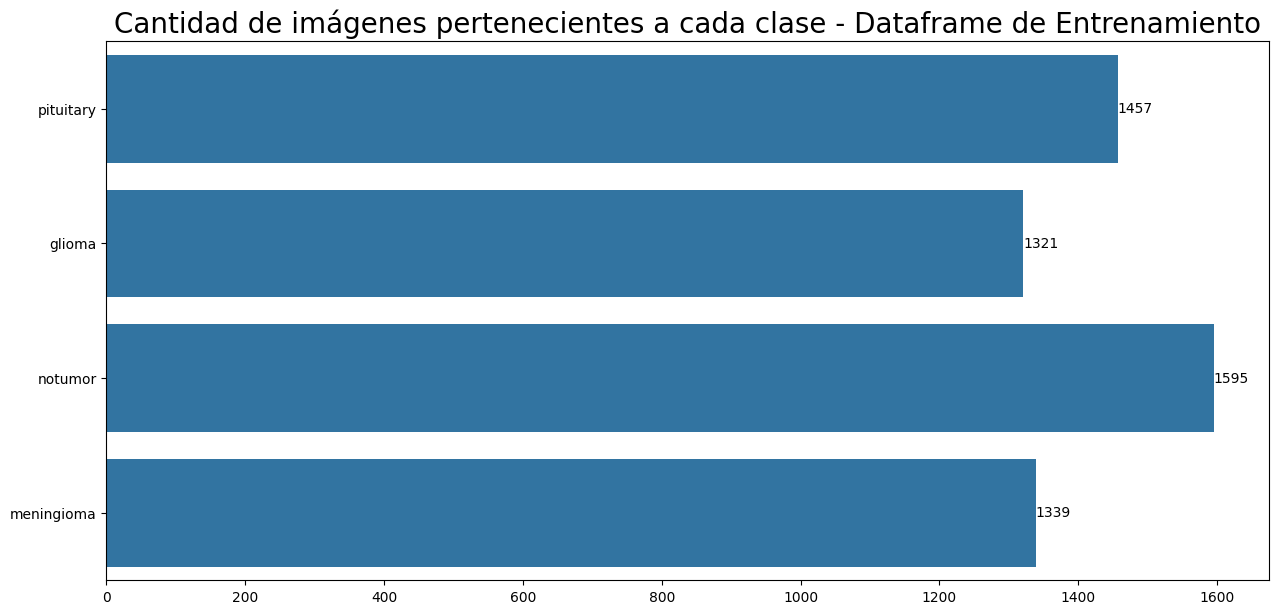

In [ ]:
# Cantidad de imágenes pertenecientes a cada clase - DataFrame de Entrenamiento
# =============================================================================

plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Cantidad de imágenes pertenecientes a cada clase - Dataframe de Entrenamiento', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

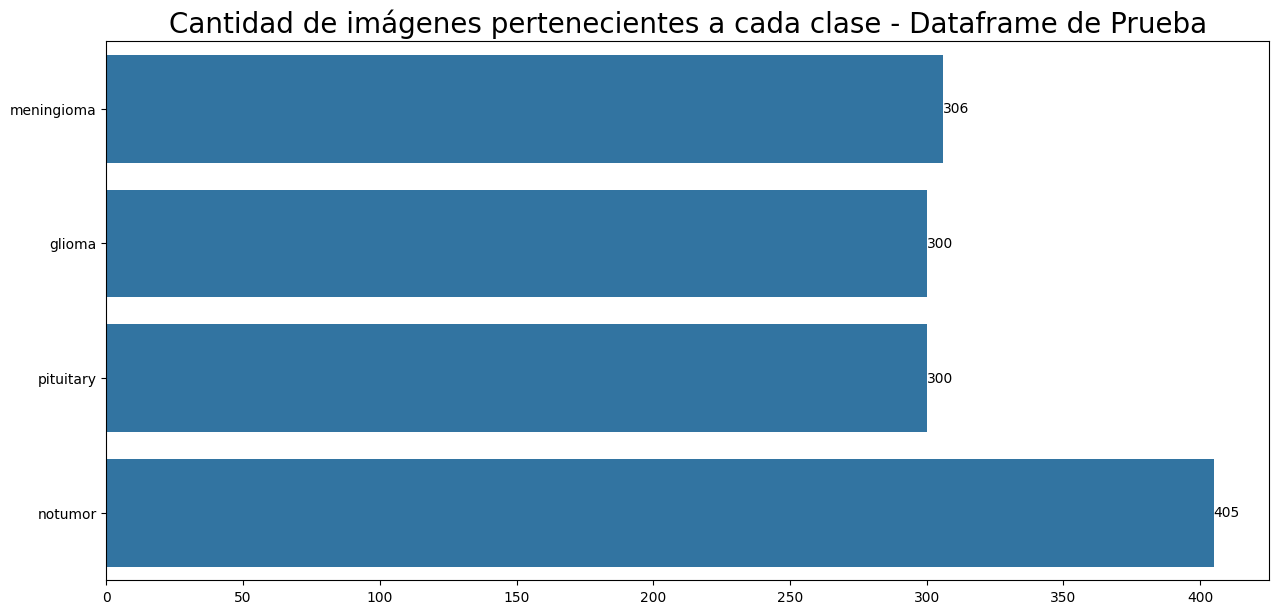

In [ ]:
# Cantidad de imágenes pertenecientes a cada clase - DataFrame de Prueba
# ======================================================================


plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df , y=ts_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Cantidad de imágenes pertenecientes a cada clase - Dataframe de Prueba', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

## División de los datos en entrenamiento, prueba y validación

In [ ]:
# El dataset de validación se obtiene diviendo la mitad del dataset de test

valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)

In [ ]:
print(f"El dataframe de entranemiento tiene {valid_df.shape[0]} filas y {valid_df.shape[1]} columnas")

El dataframe de entranemiento tiene 655 filas y 2 columnas


## Preprocesamiento de Datos

ImageDataGenerator es una clase utilizada para generar lotes de tensores de imagen con aumentos de datos en tiempo real. Esto es muy útil para el entrenamiento de modelos de redes neuronales, ya que permite ampliar artificialmente el tamaño del dataset aplicando transformaciones aleatorias a las imágenes de entrenamiento.

In [ ]:
batch_size = 32
img_size = (224,224)

* __batch_size:__ define el número de imágenes que se procesarán en cada lote durante el entrenamiento. En este caso, el tamaño del lote es 32.
* __img_size:__ define el tamaño al que se redimensionarán todas las imágenes de entrada. Aquí, las imágenes se redimensionarán a 224x224 píxeles, que es el tamaño predeterminado de la imagen de entrada para este modelo.

In [ ]:
tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))

* __ImageDataGenerator(brightness_range=(.8, 1.2)):__ crea un objeto ImageDataGenerator para el conjunto de entrenamiento. Este generador ajustará el brillo de las imágenes en un rango entre 0.8 y 1.2 del brillo original. Esto es una técnica de aumento de datos que ayuda a mejorar la generalización del modelo al exponerlo a diferentes condiciones de iluminación.

In [ ]:
gen = ImageDataGenerator()

* __ImageDataGenerator()__: crea un objeto ImageDataGenerator sin especificar ningún aumento de datos. Este generador se utilizará para los conjuntos de validación y prueba, donde generalmente no se desea aplicar aumentos para evaluar el rendimiento real del modelo.

## Flujo de imágenes de entrenamiento

In [ ]:
tr_gen = tr_gen.flow_from_dataframe(tr_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size)

Found 5712 validated image filenames belonging to 4 classes.


* __tr_gen.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size):__ crea un flujo de datos de imágenes a partir de un DataFrame tr_df para el entrenamiento.

* __tr_df:__ DataFrame que contiene las rutas a las imágenes (Class Path) y sus etiquetas (Class).
* __x_col:__ nombre de la columna en el DataFrame que contiene las rutas de las imágenes.
* __y_col:__ nombre de la columna en el DataFrame que contiene las etiquetas de las imágenes.
* __batch_size:__ número de imágenes por lote.
* __target_size:__ tamaño al que se redimensionarán las imágenes.

### Flujo de imágenes de validación

In [ ]:
valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size)

Found 655 validated image filenames belonging to 4 classes.


* __valid_gen.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size):__ similar al anterior, pero para el conjunto de validación valid_df

* __ts_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size, shuffle=False):__ crea un flujo de datos de imágenes a partir de un DataFrame ts_df para el conjunto de prueba.
* __shuffle=False:__ asegura que las imágenes no se barajen, lo cual es útil para evaluar el rendimiento del modelo de manera consistente.

In [ ]:
ts_gen = gen.flow_from_dataframe(ts_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size,shuffle=False)

Found 656 validated image filenames belonging to 4 classes.


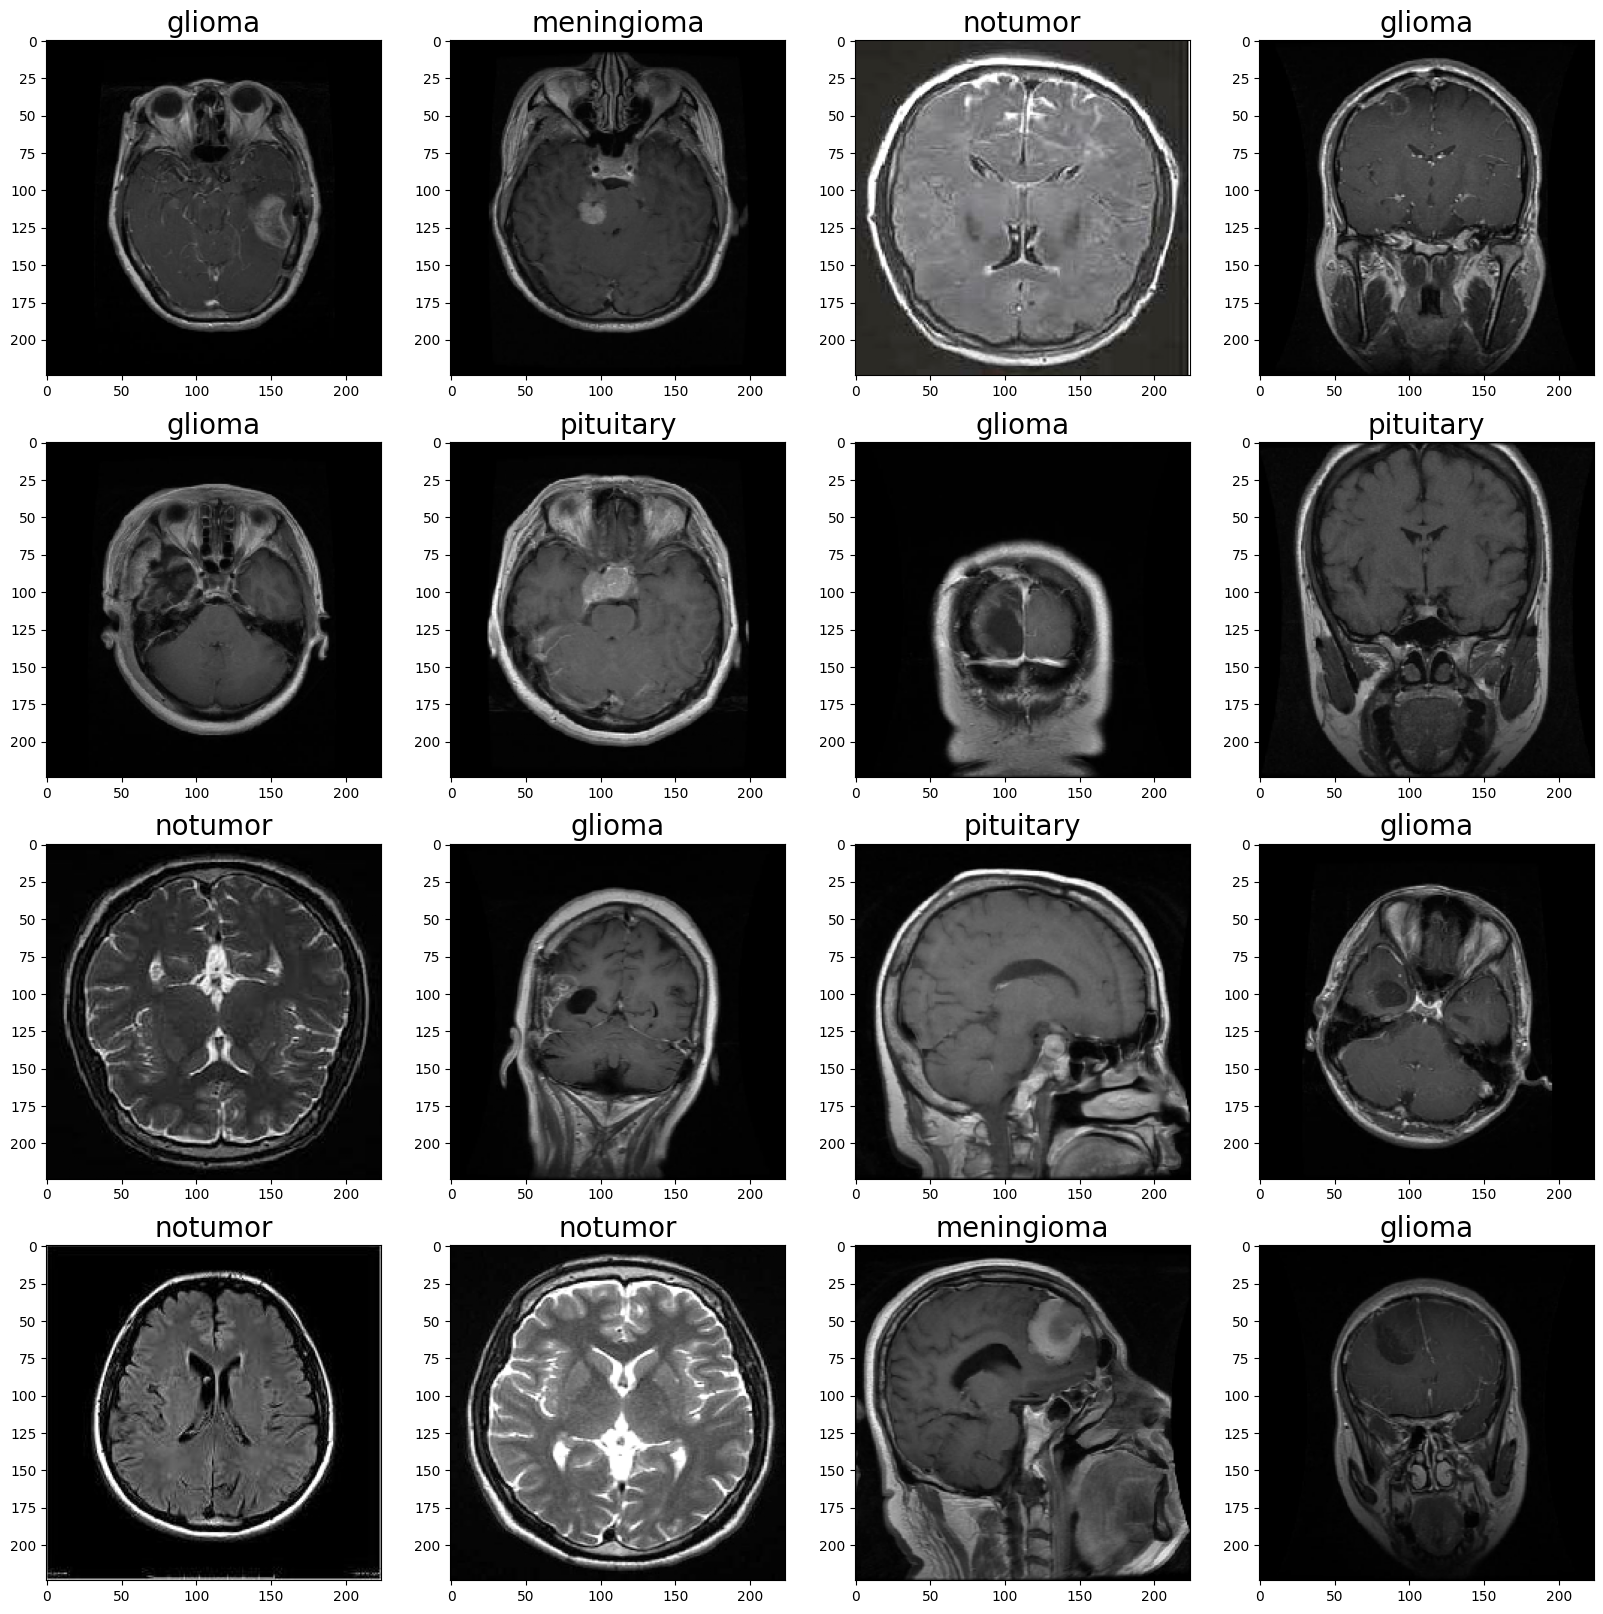

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)
plt.figure(figsize= (20, 20))
for i in range(16):
  plt.subplot(4,4,i+1)
  image = images[i] / 255
  plt.imshow(image)
  index = np.argmax(labels[i])
  class_name = classes[index]
  plt.title(class_name, color='k', fontsize=20)
plt.show()

## Creación del Modelo de Deep Learning VVG19

In [ ]:
 # hiperparámetros
base_learning_rate = 1e-5
batch_size=32
epochs = 15

### Model
Defining the model in below function.
Let's keep block -1,2,3 frozen and train blocks 4 and 5 along with adding Batch Norm.
Definiendo el modelo en la siguiente función. Mantengamos el bloque -1,2,3 congelado y entrenemos los bloques 4 y 5 junto con la adición de Batch Norm.

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv1', trainable=False)(img_input)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block1_pool', trainable=False)(x)

    #Block 2
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='block2_conv1',trainable=False)(x)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='block2_conv2', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block2_pool', trainable=False)(x)

    #Block 3
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv1',trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv2', trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv3', trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv4', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool', trainable=False)(x)

    #Block 4
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv1')(x)
    x = BatchNormalization(name='block4_bn1')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv2')(x)
    x = BatchNormalization(name='block4_bn2')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv3')(x)
    x = BatchNormalization(name='block4_bn3')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block4_pool')(x)

    #Block 5
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv1')(x)
    x = BatchNormalization(name='block5_bn1')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv2')(x)
    x = BatchNormalization(name='block5_bn2')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv3')(x)
    x = BatchNormalization(name='block5_bn3')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block5_pool')(x)

    #Other layers
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout_1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout_2')(x)
    x = Dense(4, activation='softmax', name='predictions')(x)


    model = Model(inputs=img_input, outputs=x)
    return model

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model=create_model()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_bn1 (BatchNormalization)      │ (None, 28, 28, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_bn2 (BatchNormalization)      │ (None, 28, 28, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_bn3 (BatchNormalization)      │ (None, 28, 28, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,598,916 (532.53 MB)

 Trainable params: 137,267,204 (523.63 MB)

 Non-trainable params: 2,331,712 (8.89 MB)

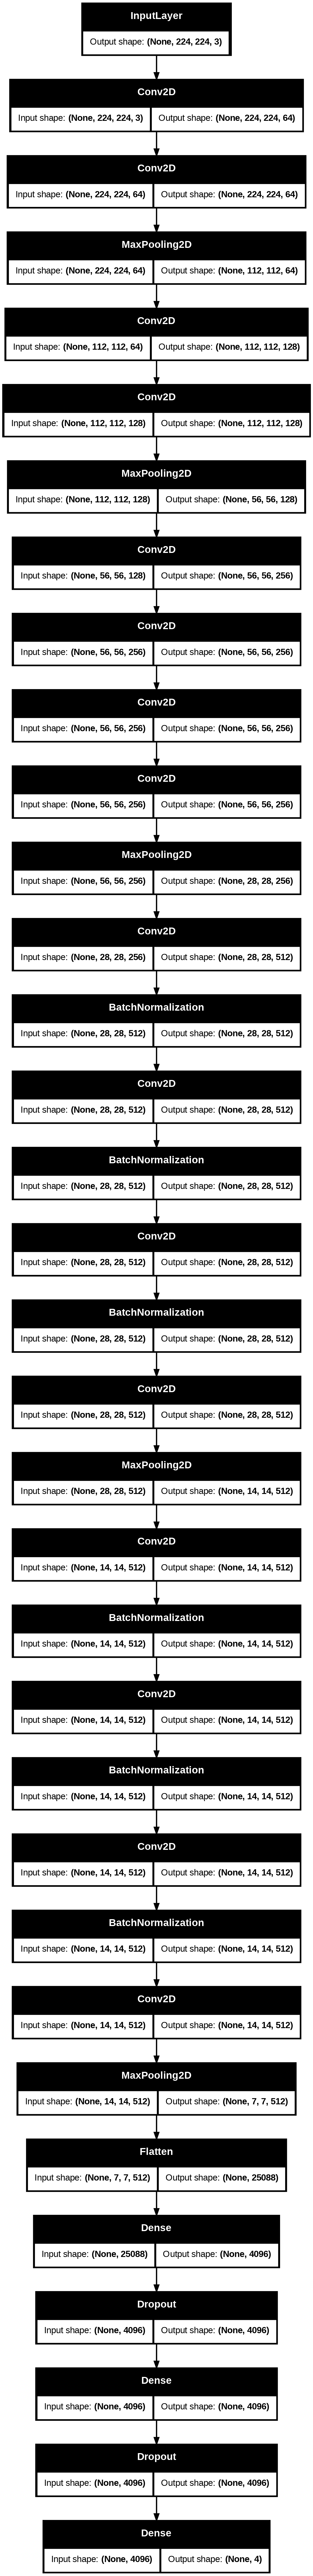

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Ahora vamos a utilizar los pesos de Keras modelo pre-entrenado (VGG19) y se aplican a los 3 primeros bloques del modelo personalizado y congelarlo.

In [ ]:
layer_count = 0
for layer in model.layers:
    if layer.name[:6] in ['block1', 'block2', 'block3']:
        model.layers[layer_count].set_weights = base_model.layers[layer_count].get_weights()
    layer_count += 1

Optimizador

In [ ]:
# Uso del optimizador SGD

sgd= SGD(learning_rate=base_learning_rate,momentum=0.95)

model.compile(loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), # Use tf.keras.metrics.Precision
                        tf.keras.metrics.Recall()], optimizer=sgd)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                                patience=3,
                                verbose=1,
                                factor=0.2,
                                min_lr=1e-7)

In [ ]:
# Define el nombre del archivo para guardar los pesos del modelo
filepath = 'vgg_19_best_model.weights.h5'

# Crea el objeto ModelCheckpoint
model_chkpoint = ModelCheckpoint(filepath=filepath,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 verbose=1)

In [ ]:
# Obtener un lote de datos
x_batch, y_batch = next(tr_gen)

# Imprimir las formas
print(x_batch.shape)  # Debe ser (batch_size, 150, 150, 3) para imágenes RGB
print(y_batch.shape)  # Debe ser (batch_size, 4) para 'categorical'

# Predecir en un lote de datos
y_pred = model.predict(x_batch)
print(y_pred.shape)  # Debe ser (batch_size, 4)

(32, 224, 224, 3)
(32, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
(32, 4)


In [ ]:
# Entrenar el modelo
hist=model.fit(tr_gen,
          epochs=epochs,
          steps_per_epoch=tr_gen.n // tr_gen.batch_size,
          callbacks=[reduce_lr, model_chkpoint],
          validation_data=valid_gen,
          validation_steps=valid_gen.n // valid_gen.batch_size)


Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3780 - loss: 1.8132 - precision: 0.4049 - recall: 0.3175 
Epoch 1: val_loss improved from inf to 1.21626, saving model to vgg_19_best_model.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 2178s 12s/step - accuracy: 0.3786 - loss: 1.8111 - precision: 0.4055 - recall: 0.3181 - val_accuracy: 0.4406 - val_loss: 1.2163 - val_precision: 0.7895 - val_recall: 0.1406 - learning_rate: 1.0000e-05
Epoch 2/15
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1:12 411ms/step - accuracy: 0.5938 - loss: 1.2128 - precision: 0.6667 - recall: 0.5625
Epoch 2: val_loss did not improve from 1.21626
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.5938 - loss: 1.2128 - precision: 0.6667 - recall: 0.5625 - val_accuracy: 0.4000 - val_loss: 1.3464 - val_precision: 1.0000 - val_recall: 0.1333 - learning_rate: 1.0000e-05
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6242 - loss: 0.9907 - precision: 0.6603 - recall: 0.5703
Epoch 3: val_loss improve

In [ ]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

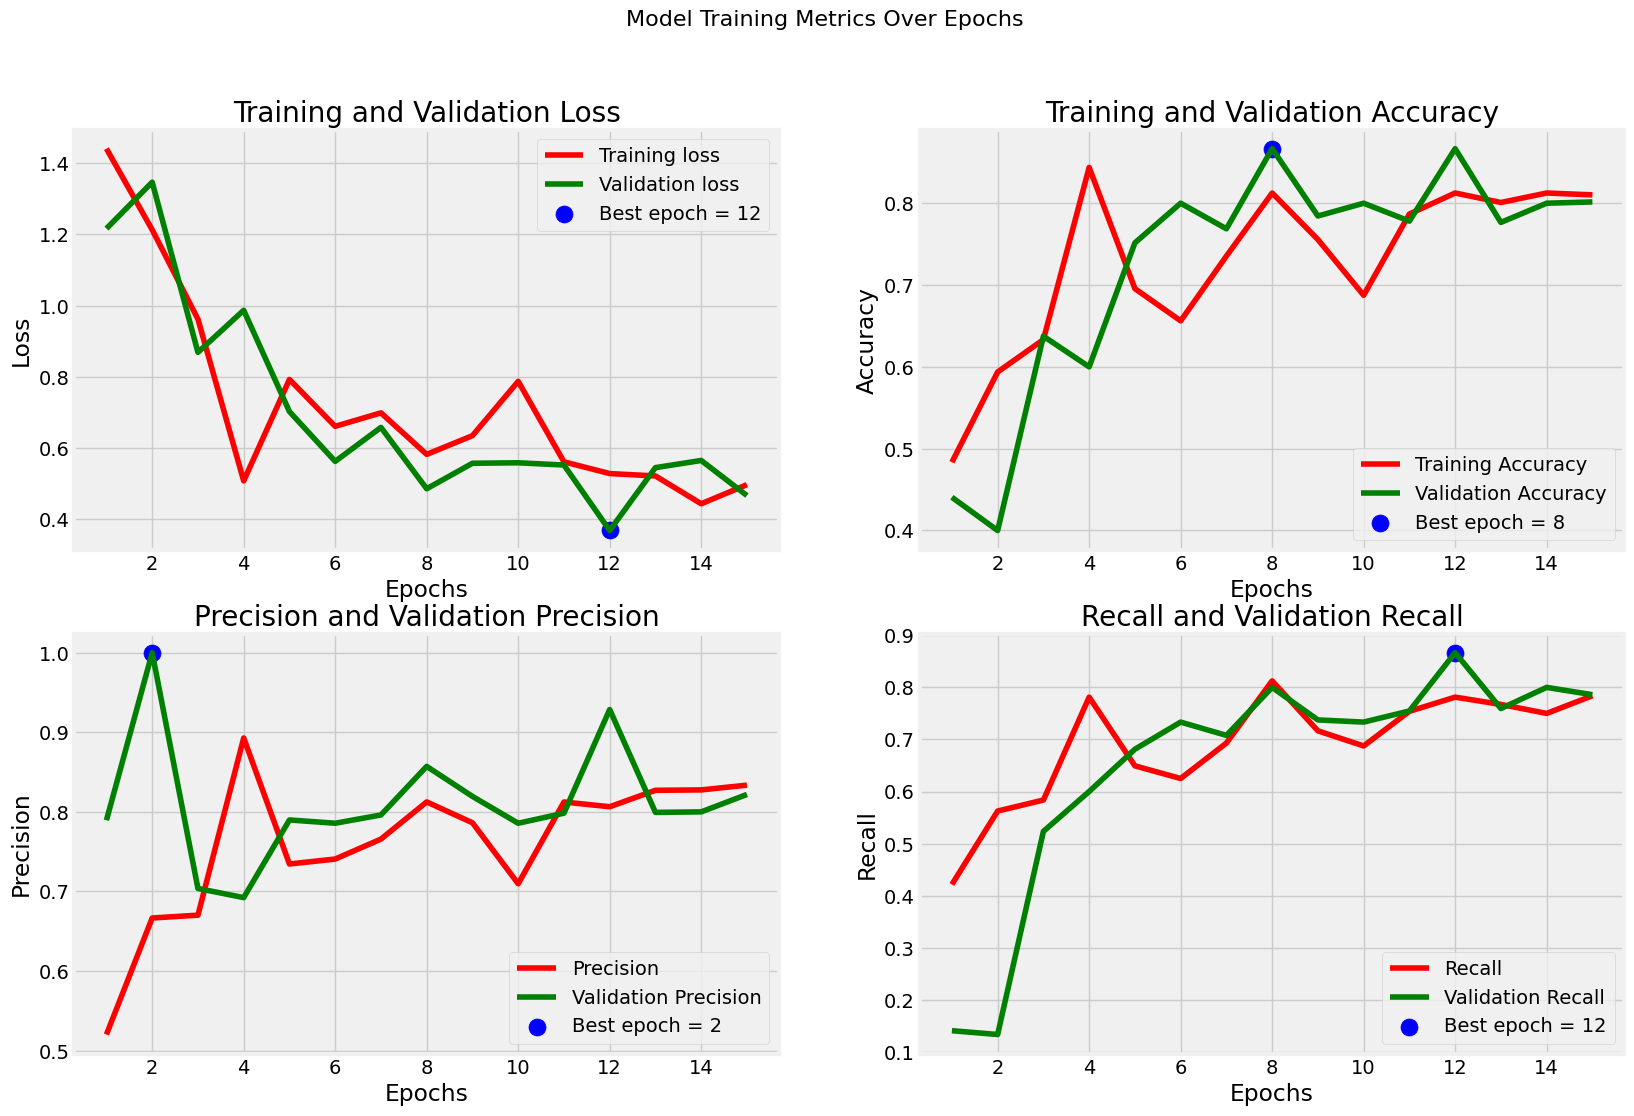

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

### Evaluación

In [ ]:
ts_gen = gen.flow_from_dataframe(ts_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size,shuffle=False)

Found 656 validated image filenames belonging to 4 classes.


In [ ]:
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.8774 - loss: 0.3206 - precision: 0.8941 - recall: 0.8618
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.7965 - loss: 0.4586 - precision: 0.8208 - recall: 0.7778
21/21 ━━━━━━━━━━━━━━━━━━━━ 260s 13s/step - accuracy: 0.8026 - loss: 0.4974 - precision: 0.8165 - recall: 0.7698
Train Loss:  0.33148324489593506
Train Accuracy:  0.8742997050285339
--------------------
Validation Loss:  0.46342313289642334
Validation Accuracy:  0.8030534386634827
--------------------
Test Loss:  0.44856247305870056
Test Accuracy:  0.8185975551605225


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step


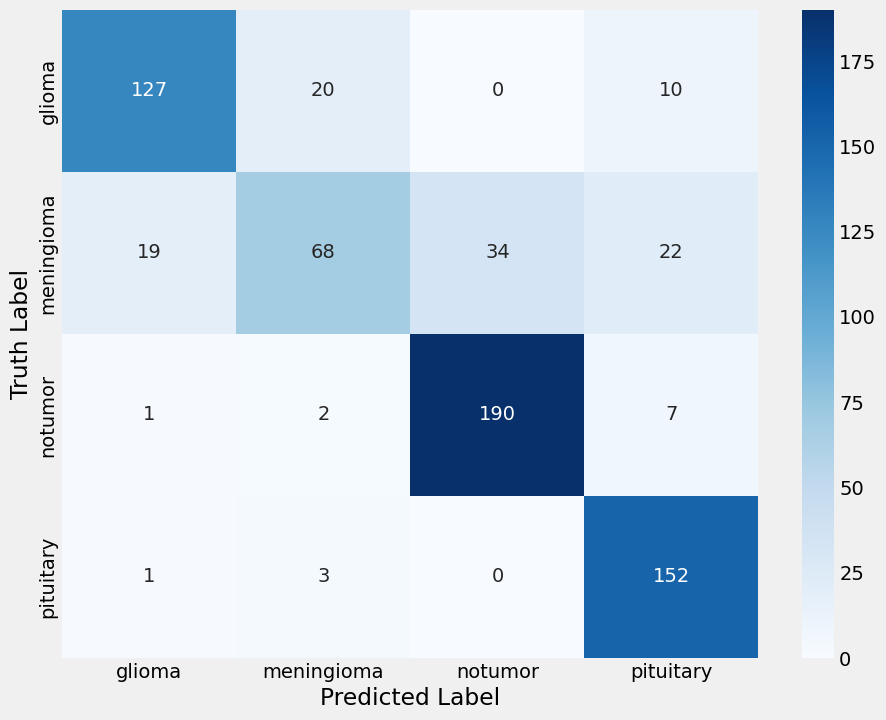

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       157
           1       0.73      0.48      0.58       143
           2       0.85      0.95      0.90       200
           3       0.80      0.97      0.88       156

    accuracy                           0.82       656
   macro avg       0.81      0.80      0.80       656
weighted avg       0.81      0.82      0.81       656



### Prueba

Para predecir , se coloca una imagen de Testing

In [ ]:
def predict(img_path):
  import numpy as np
  import matplotlib.pyplot as plt
  from PIL import Image
  label = list(class_dict.keys())
  plt.figure(figsize=(12, 12))
  img = Image.open(img_path)
  resized_img = img.resize((224, 224))
  img = np.asarray(resized_img)
  img = np.expand_dims(img, axis=0)
  predictions = model.predict(img)
  probs = list(predictions[0])
  labels = label
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probs)
  plt.xlabel('Probability', fontsize=15)
  ax = plt.gca()
  ax.bar_label(bars, fmt = '%.2f')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


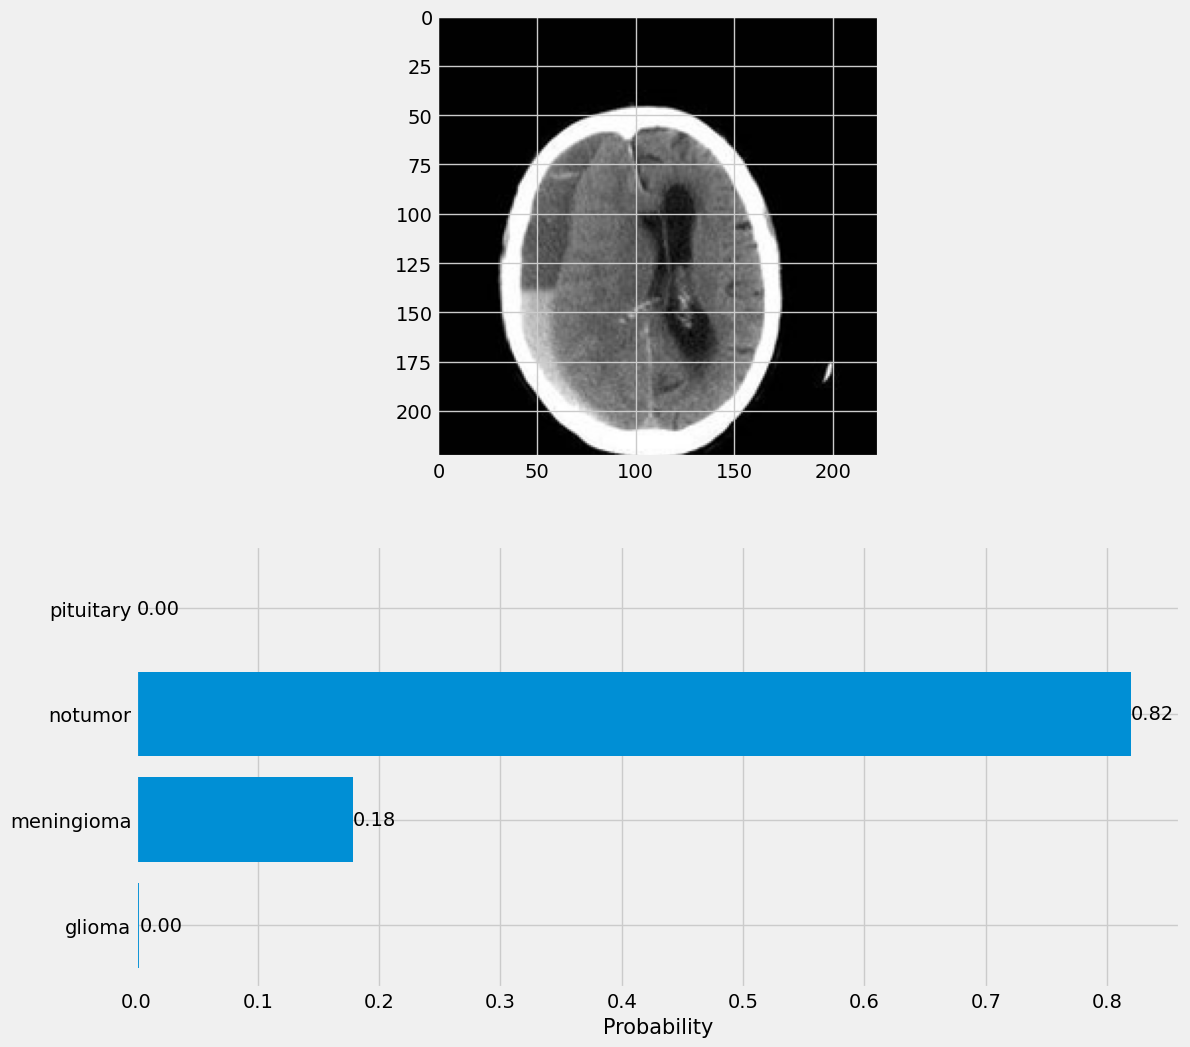

In [ ]:
predict("/content/drive/MyDrive/Colab Notebooks/VGG19/Trabajovvg19/Testing/notumor/Te-noTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


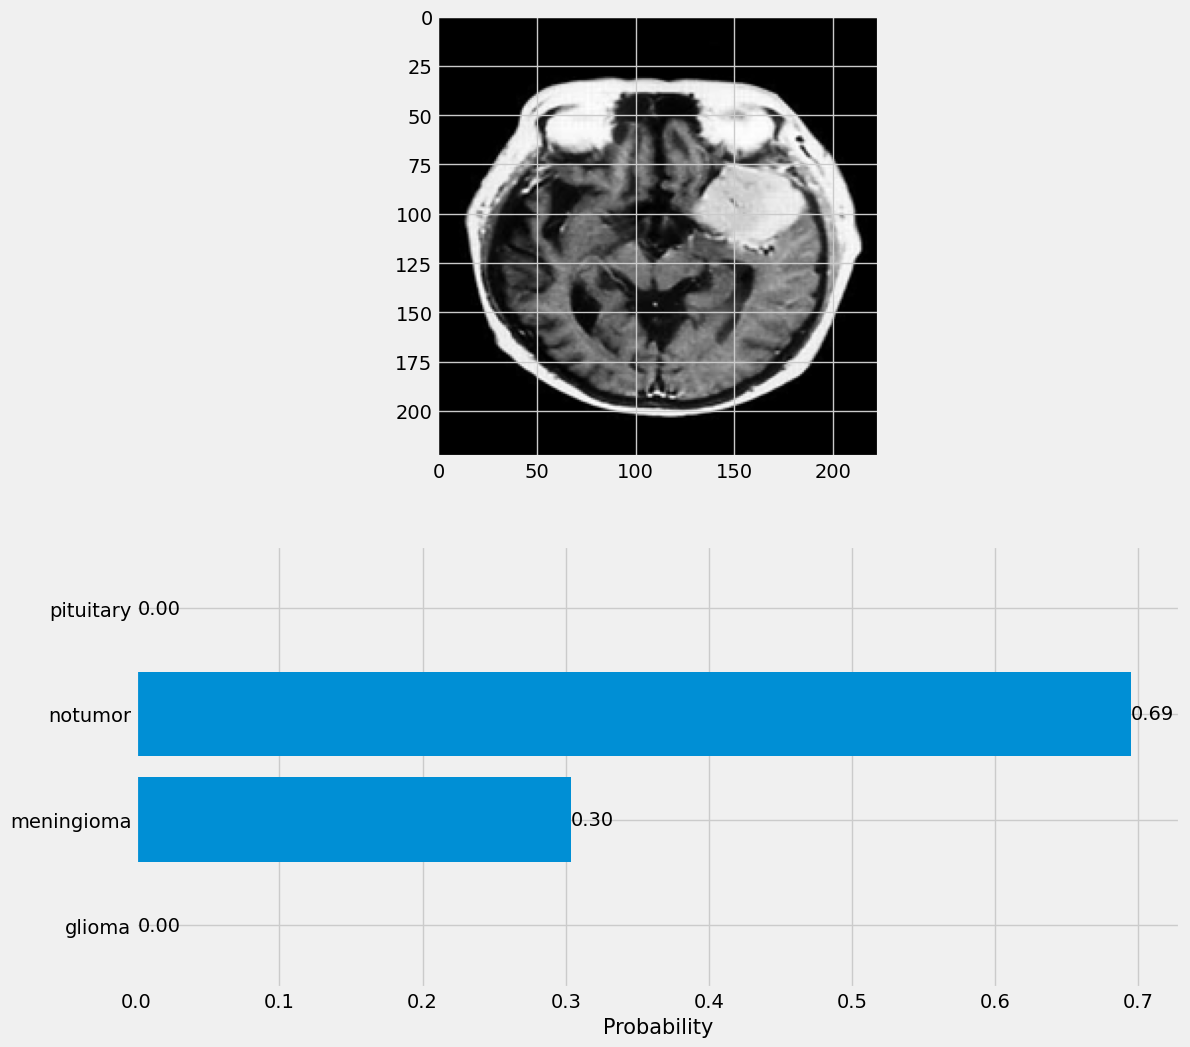

In [ ]:
predict("/content/drive/MyDrive/Colab Notebooks/VGG19/Trabajovvg19/Testing/meningioma/Te-me_0034.jpg")